In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera
from tqdm import tqdm
from load import get_btch
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {'data_dir'       : '/data/LiftPose3D/monkey/OMS_Dataset', #mac/ubuntu path
             #'data_dir'       : r'\Users\NeLy\Desktop\OMS_Dataset\OMS_Dataset', #windows path
             'out_dir'        : '/data/LiftPose3D/monkey/OMS_Dataset/out', 
             'train_subjects' : ["7", "9a", "9b", "10", "11"],
             'test_subjects'  : ["9"]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load Data

In [6]:
# takes around a minute
train_2d, train_3d, train_keys = list(), list(), list()
for btch in par_train["train_subjects"]:
    Data, _ = get_btch(btch, par_train["data_dir"])
    for idx, (k,v) in enumerate(Data.items()):
        train_2d.append(Data[k]["points2d"])
        train_3d.append(Data[k]["points3d"])
        train_keys.append(k)

test_2d, test_3d, test_keys = list(), list(), list()
for btch in par_train["test_subjects"]:
    Data, _ = get_btch(btch, par_train["data_dir"])
    for idx, (k,v) in enumerate(Data.items()):
        test_2d.append(Data[k]["points2d"])
        test_3d.append(Data[k]["points3d"])
        test_keys.append(k)

train_2d, train_3d = np.stack(train_2d), np.stack(train_3d)
test_2d, test_3d = np.stack(test_2d), np.stack(test_3d)

#remove points with with large variance for easier training
good_ind = np.where((train_2d.reshape(train_2d.shape[0], -1)).std(axis=1) < 1000)[0]
train_2d = train_2d[good_ind]
train_3d = train_3d[good_ind]

# l2 normalization
train_2d /= np.linalg.norm(train_2d, axis=(-1,-2), keepdims=True)
test_2d /= np.linalg.norm(test_2d, axis=(-1,-2), keepdims=True)

# Train Model

In [7]:
from liftpose.main import train as lp3d_train

lp3d_train(train_2d={'train': train_2d}, test_2d={'test': test_2d}, 
           train_3d={'train': train_3d}, test_3d={'test': test_3d},
           roots=par['roots'], target_sets=par['target_sets'], out_dir=par['out_dir'],
           training_kwargs={"epochs":30, "lr_decay":10000, "dropout":0.2})

[main.py:190]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/monkey/OMS_Dataset/out/stat_2d.pth.tar.
[main.py:209]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/monkey/OMS_Dataset/out/stat_3d.pth.tar.
[main.py:237]:INFO:Starting training model.
[main.py:248]:DEBUG:
==================Options=================
[main.py:249]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/monkey/OMS_Dataset/out',
    'drop_input': 0.0,
    'dropout': 0.2,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 10000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/monkey/OMS_Dataset/out',
    'out_dir': '/data/LiftPose3D/monkey/OMS_Dataset/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:250]:DEBUG:==========================================

[lift.py:44]:INFO:Training on the d

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.41889|: 100%|██████████| 5607/5607 [00:32<00:00, 175.00it/s]
Epoch 001 | LR  0.00090 | Loss Test  0.22643 | Loss Train  0.31731|: 100%|██████████| 5607/5607 [00:31<00:00, 179.36it/s]
Epoch 002 | LR  0.00090 | Loss Test  0.21732 | Loss Train  0.29470|: 100%|██████████| 5607/5607 [00:31<00:00, 177.38it/s]
Epoch 003 | LR  0.00081 | Loss Test  0.20976 | Loss Train  0.28310|: 100%|██████████| 5607/5607 [00:31<00:00, 178.02it/s]
Epoch 004 | LR  0.00081 | Loss Test  0.21773 | Loss Train  0.27532|: 100%|██████████| 5607/5607 [00:31<00:00, 177.46it/s]
Epoch 005 | LR  0.00073 | Loss Test  0.19644 | Loss Train  0.26929|: 100%|██████████| 5607/5607 [00:31<00:00, 175.99it/s]
Epoch 006 | LR  0.00073 | Loss Test  0.19308 | Loss Train  0.26511|: 100%|██████████| 5607/5607 [00:31<00:00, 179.51it/s]
Epoch 007 | LR  0.00066 | Loss Test  0.19561 | Loss Train  0.26117|: 100%|██████████| 5607/5607 [00:31<00:00, 180.58it/s]
Epoch 008 | LR  0.00059 

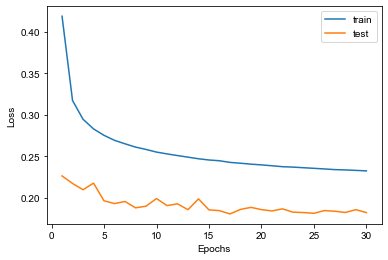

In [15]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)
#plt.savefig('loss.svg')

In [2]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

from liftpose.postprocess import load_test_results
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, _ = load_test_results(par['out_dir'], stat_2d, stat_3d)

[main.py:334]:INFO:starting testing in path: /data/LiftPose3D/monkey/OMS_Dataset/out
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:71]:INFO:total params: 4.27M
[lift.py:79]:INFO:loading ckpt from '/data/LiftPose3D/monkey/OMS_Dataset/out/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 17 | err: 0.18061591590428774)
[lift.py:118]:INFO:Saving results: /data/LiftPose3D/monkey/OMS_Dataset/out/test_results.pth.tar


# Violin Plots

(0.0, 0.15)

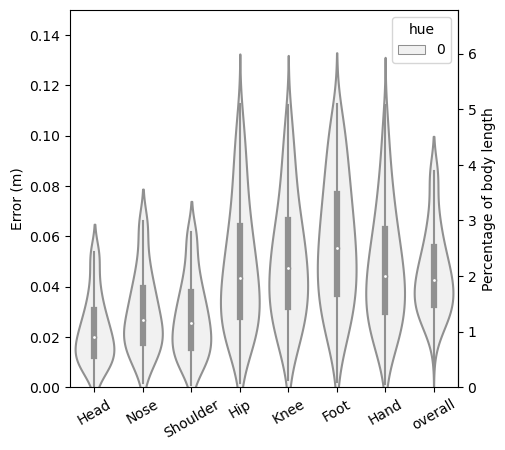

In [4]:
%matplotlib inline
from liftpose.plot import violin_plot
plt.figure(figsize=(5,5), dpi=100)

# concat left and right limbs
names = par_data["vis"]["names"]
r = ['Head', 'Nose', 'RShoulder', 'Hip',  'RKnee', 'RFoot', 'RHand']
l = ['Head', 'Nose', 'Shoulder',  'Hip',  'Knee', 'Foot', 'Hand']
r_indices = [names.index(r_) for r_ in r]
l_indices = [names.index(l_) for l_ in l]
test_3d_gt_ord = np.concatenate([test_3d_gt[:,r_indices], test_3d_gt[:, l_indices]])
test_3d_pred_ord = np.concatenate([test_3d_pred[:,r_indices], test_3d_pred[:, l_indices]])

violin_plot(plt.gca(), gt=test_3d_gt_ord, pred=test_3d_pred_ord, good_keypts=np.ones_like(test_3d_pred_ord), 
            name=l, units='m', body_length=2.21)
plt.ylim([0,0.15])

# Plot single video frame

In [11]:
Data, cameras = get_btch('9', par_train['data_dir'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


2607 ('9', 12240, '18260989')


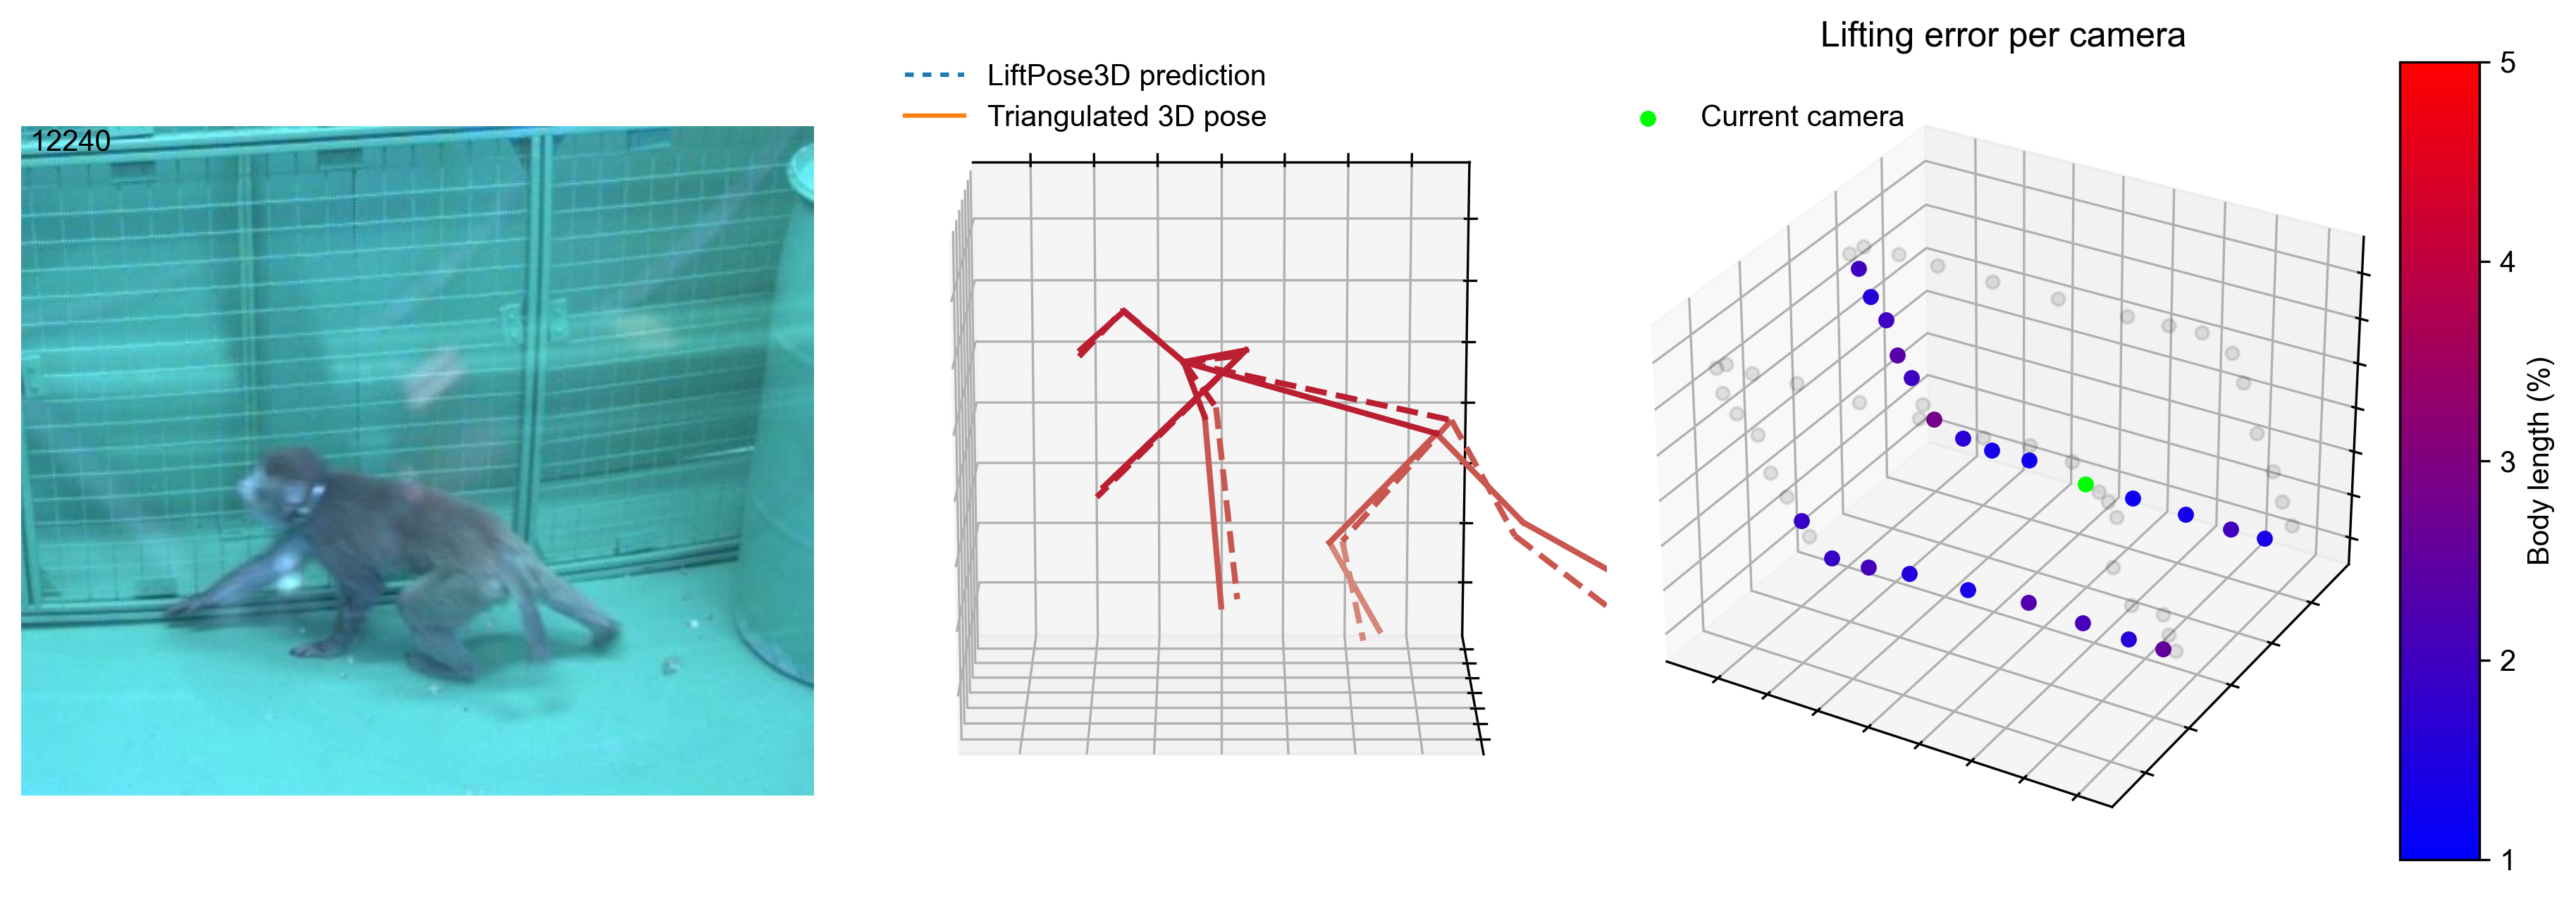

In [13]:
%matplotlib inline
from liftpose.plot import plot_pose_3d
from plot_util import *
from matplotlib.ticker import NullFormatter
import matplotlib.colors as mcol
import matplotlib as mpl
import matplotlib.cm as cm
mpl.pyplot.rcParams["font.family"] = ['Arial']
mpl.rcParams.update({'font.size': 10})

# define axis
fig = plt.figure(figsize=(15,5),dpi=300)
plt.subplots_adjust(wspace=0, hspace=0)
gs1 = fig.add_gridspec(nrows=1, ncols=31)
ax2d = fig.add_subplot(gs1[:, :10])
ax3d = fig.add_subplot(gs1[:, 10:20], projection='3d')
ax3d_cameras = fig.add_subplot(gs1[:, 20:30], projection='3d')
ax_bar = fig.add_subplot(gs1[:, -1])

# load image and plot
idx = np.random.randint(test_3d_pred.shape[0])
k = list(Data.keys())[idx]
print(idx, k)

btch, img_id, cam = k
img_name = os.path.join(par['data_dir'], 'Images', 'batch' + str(btch) + '_' + str(img_id).zfill(9) + '_' + str(cam) + '.jpg')
ax2d.imshow(plt.imread(img_name))
ax2d.text(x=5, y=15, s=f"{img_id}")

ax3d.view_init(elev=-75, azim=-90)
plot_pose_3d(ax=ax3d, 
             bones=par_data["vis"]["bones"], 
             pred=test_3d_pred[idx],
             tar=test_3d_gt[idx],
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"], 
             normalize=True,
             legend=True)

mi, ma = 1 / 100 * 2.2, 5 / 100 * 2.2
err = err_for_frame(Data, cameras, img_id, test_3d_gt, test_3d_pred)
plot_cameras_err(ax=ax3d_cameras, err=err, mi=mi, ma=ma, cameras=cameras, curr_camera=cam)

ax2d.axis('off')
lim = [-0.75, 0.75]
ax3d.set_xlim(lim)
ax3d.set_ylim(lim)
ax3d.set_zlim(lim)

# remove ticks
ax3d.xaxis.set_major_formatter(NullFormatter())
ax3d.yaxis.set_major_formatter(NullFormatter())
ax3d.zaxis.set_major_formatter(NullFormatter())
ax3d_cameras.xaxis.set_major_formatter(NullFormatter())
ax3d_cameras.yaxis.set_major_formatter(NullFormatter())
ax3d_cameras.zaxis.set_major_formatter(NullFormatter())

# setting titles
ax3d_cameras.set_title('Lifting error per camera')
cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
norm = mpl.colors.Normalize(vmin=mi/2.2 * 100, vmax=ma/2.2 * 100)
cb1 = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap,
                                norm=norm,
                                orientation='vertical', ticks=[1,2,3,4,5])

p1 = ax3d_cameras.scatter(0,0,0, c=(0,1,0))
ax3d_cameras.legend([(p1)],
        ["Current camera"],
        numpoints=1,
        loc=(0.0, 0.9),
        frameon=False,
        )
p1.remove()
        
cb1.set_label('Body length (%)')